# Training Environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch  # Package name: torch (for pip), pytorch (for conda)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

class BasicDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return dict(X=self.X[idx], y=self.y[idx])
    
    def __len__(self):
        return self.X.shape[0]

## Prepare Data

In [2]:
import torchvision.datasets as datasets

mnist = False
cifar10 = True
cifar100 = False
assert mnist ^ cifar10 ^ cifar100

n_classes = 10
if mnist:
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
if cifar10:
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
if cifar100:
    n_classes = 100
    trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=None)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=None)

print(trainset)
print(testset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test


In [3]:
def to_rgb(x_grey: torch.Tensor) -> torch.Tensor:
    if len(x_grey.size()) == 3:
        helper = torch.unsqueeze(x_grey, 1)
        return helper.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 1:
        return x_grey.repeat(1, 3, 1, 1).float()
    elif len(x_grey.size()) == 4 and x_grey.size()[1] == 3:
        return x_grey
    elif len(x_grey.size()) == 4:
        raise ValueError(f'The size of this image tensor is not valid.\
        A 4th order image tensor must have dim1==1 (grey-scale) or dim1==3 (rgb).\
        Unknown format cannot be transformed to rgb.')
    else:
        raise ValueError(f'The size of this image-tensor is not valid.\
        Must be either 3rd (grey-scale) order tensor or 4th order tensor (rgb).\
        Got order {len(x_grey.size())}')
        
def swap_data(X):
    X1 = np.swapaxes(X, 1, 3)
    X2 = np.swapaxes(X1, 2, 3)
    return X2

if mnist:
    X_train_grey = trainset.train_data
    X_train = to_rgb(X_train_grey)
    X_test_grey = testset.test_data
    X_test = to_rgb(X_test_grey)
    y_train = trainset.train_labels
    y_test = testset.test_labels
else:
    X_train = torch.tensor(swap_data(trainset.data))
    y_train = torch.tensor(trainset.targets)
    X_test = torch.tensor(swap_data(testset.data))
    y_test = torch.tensor(testset.targets)
    
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: torch.Size([50000, 3, 32, 32])
y_train: torch.Size([50000])
X_test: torch.Size([10000, 3, 32, 32])
y_test: torch.Size([10000])


## Model load, modifications and GPU optimization

In [4]:
# https://github.com/kuangliu/pytorch-cifar/blob/49b7aa97b0c12fe0d4054e670403a16b6b834ddd/models/resnet.py

'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

#test()

In [5]:
from torchvision import models

#model = ResNet18() # set model here
model = models.resnet18(pretrained=False)
in_ftr = model.fc.in_features
out_ftr = n_classes
model.fc = nn.Linear(in_ftr,out_ftr,bias=True)
    
dataset_train = BasicDataset(X_train, y_train)
dataset_test = BasicDataset(X_test, y_test)

Check specs for GPU-based training.

In [6]:
print('cuda available:', torch.cuda.is_available())
print('cuda device name:', torch.cuda.get_device_name())
print('cuda device id', torch.cuda.current_device())

cuda available: True
cuda device name: NVIDIA GeForce 940MX
cuda device id 0


Move model and data to GPU.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train.to(device)
print('worked?', X_train.to(device).is_cuda)

worked? True


## Adam

In [8]:
class Adam(optim.Optimizer):
    r"""Implements Adam algorithm.
    .. math::
       \begin{aligned}
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{input}      : \gamma \text{ (lr)}, \beta_1, \beta_2
                \text{ (betas)},\theta_0 \text{ (params)},f(\theta) \text{ (objective)}          \\
            &\hspace{13mm}      \lambda \text{ (weight decay)},  \: amsgrad                      \\
            &\textbf{initialize} :  m_0 \leftarrow 0 \text{ ( first moment)},
                v_0\leftarrow 0 \text{ (second moment)},\: \widehat{v_0}^{max}\leftarrow 0\\[-1.ex]
            &\rule{110mm}{0.4pt}                                                                 \\
            &\textbf{for} \: t=1 \: \textbf{to} \: \ldots \: \textbf{do}                         \\
            &\hspace{5mm}g_t           \leftarrow   \nabla_{\theta} f_t (\theta_{t-1})           \\
            &\hspace{5mm}\textbf{if} \: \lambda \neq 0                                           \\
            &\hspace{10mm} g_t \leftarrow g_t + \lambda  \theta_{t-1}                            \\
            &\hspace{5mm}m_t           \leftarrow   \beta_1 m_{t-1} + (1 - \beta_1) g_t          \\
            &\hspace{5mm}v_t           \leftarrow   \beta_2 v_{t-1} + (1-\beta_2) g^2_t          \\
            &\hspace{5mm}\widehat{m_t} \leftarrow   m_t/\big(1-\beta_1^t \big)                   \\
            &\hspace{5mm}\widehat{v_t} \leftarrow   v_t/\big(1-\beta_2^t \big)                   \\
            &\hspace{5mm}\textbf{if} \: amsgrad                                                  \\
            &\hspace{10mm}\widehat{v_t}^{max} \leftarrow \mathrm{max}(\widehat{v_t}^{max},
                \widehat{v_t})                                                                   \\
            &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} - \gamma \widehat{m_t}/
                \big(\sqrt{\widehat{v_t}^{max}} + \epsilon \big)                                 \\
            &\hspace{5mm}\textbf{else}                                                           \\
            &\hspace{10mm}\theta_t \leftarrow \theta_{t-1} - \gamma \widehat{m_t}/
                \big(\sqrt{\widehat{v_t}} + \epsilon \big)                                       \\
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
            &\bf{return} \:  \theta_t                                                     \\[-1.ex]
            &\rule{110mm}{0.4pt}                                                          \\[-1.ex]
       \end{aligned}
    For further details regarding the algorithm we refer to `Adam: A Method for Stochastic Optimization`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, cus=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)
        self.lr = lr

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    # update the steps for each param group update
                    state['step'] += 1
                    # record the step after step update
                    state_steps.append(state['step'])
            
            if cus:
                cus_adam(params_with_grad,
                         grads,
                         exp_avgs,
                         exp_avg_sqs,
                         max_exp_avg_sqs,
                         state_steps,
                         amsgrad=group['amsgrad'],
                         beta1=beta1,
                         beta2=beta2,
                         lr=self.lr,
                         weight_decay=group['weight_decay'],
                         eps=group['eps'])
            else:
                optim._functional.adam(params_with_grad,
                       grads,
                       exp_avgs,
                       exp_avg_sqs,
                       max_exp_avg_sqs,
                       state_steps,
                       amsgrad=group['amsgrad'],
                       beta1=beta1,
                       beta2=beta2,
                       lr=self.lr,
                       weight_decay=group['weight_decay'],
                       eps=group['eps'])
        return loss

CUS-Adam

In [9]:
from typing import List
import math

def cus_adam(params: List[torch.Tensor],
         grads: List[torch.Tensor],
         exp_avgs: List[torch.Tensor],
         exp_avg_sqs: List[torch.Tensor],
         max_exp_avg_sqs: List[torch.Tensor],
         state_steps: List[int],
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    for i, param in enumerate(params):

        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        bias_correction1 = 1
        bias_correction2 = 1 - beta2 ** step

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sqs[i].sqrt() / math.sqrt(bias_correction2)).add_(eps)
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

        step_size = lr / bias_correction1

        param.addcdiv_(exp_avg, denom, value=-step_size)

In [10]:
class CLR_Adam_Scheduler():
    
    def __init__(self, optimizer: Adam, base_lr, max_lr, epochs_per_cycle, len_dataset, batch_size):
        self.iteration_number = 0
        self.optimizer = optimizer
        if max_lr < base_lr:
            raise RuntimeError('max_lr must be larger than or equal to base_lr')
        self.delta_lr = max_lr - base_lr
        if epochs_per_cycle is None:
            epochs_per_cycle = epochs
        self.iterations_per_cycle = epochs_per_cycle * (len_dataset // batch_size)
        self.update = self.delta_lr / (self.iterations_per_cycle / 2)
        
    def step(self):
        if self.iterations_per_cycle < self.iteration_number:
            self.optimizer.lr += self.update
        else:
            self.optimizer.lr -= self.update
        self.iteration_number += 1
    
    def get_last_lr(self):
        return self.optimizer.lr

## Training

In [11]:
def evaluate_model(model, dataset, batch_size=100):
    
    data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    loss = 0.0
    correct = 0
    
    for batch in data_loader:
        yhat = model.forward(batch['X'].float().to(device))
        y = batch['y'].long().to(device)
        batch_loss = f_loss(yhat, y)
        loss += batch_loss.item() * len(batch['X'])
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().item()
    accuracy = correct / len(dataset)
    print('accuracy:', f'{accuracy * 100}%')
    
    return loss, accuracy

In [12]:
def train_model(model, dataset, validation_set, base_lr=0.01, max_lr=0.01, batch_size=64, epochs=1, 
                f_opt=optim.SGD, f_loss=F.cross_entropy, epochs_per_cycle=None, cus=False):
    
    optimizer = f_opt(model.parameters(), lr=base_lr, cus=cus)
    scheduler = CLR_Adam_Scheduler(optimizer, base_lr, max_lr, epochs_per_cycle, len(dataset), batch_size)
    lr_history = []
    validation_accuracy = []
    epoch_losses = []
    validation_losses = []
    
    # evaluate initial state of model
    initial_training_loss, _ = evaluate_model(model, dataset)
    epoch_losses.append(initial_training_loss)
    validation_loss, accuracy = evaluate_model(model, validation_set)
    validation_losses.append(validation_loss)
    validation_accuracy.append(accuracy)

    for epoch in range(epochs):
        # training and epoch loss logging
        # drop last to avoid stochastic outliers in gradient update
        data_loader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        epoch_loss = 0.0 
        for batch in data_loader:
            model.zero_grad()
            yhat = model.forward(batch['X'].float().to(device))
            batch_loss = f_loss(yhat, batch['y'].long().to(device))
            epoch_loss += batch_loss.item() * len(batch['X'])
            batch_loss.backward()
            optimizer.step()
            scheduler.step()
            lr_history.append(scheduler.get_last_lr())
        print(f'Epoch {epoch+1}/{epochs} - Loss: {epoch_loss / len(dataset)} - LR: {scheduler.get_last_lr()}')
        epoch_losses.append(epoch_loss)
        
        # calculate validation loss and accuracy
        validation_loss, accuracy = evaluate_model(model, validation_set)
        validation_losses.append(validation_loss)
        validation_accuracy.append(accuracy)
        
    return (np.array(epoch_losses) / len(dataset), 
            np.array(validation_losses) / len(validation_set), 
            validation_accuracy, 
            lr_history)

In [13]:
base_lr = 0.001
max_lr = 1.0
batch_size = 128
epochs = 2
f_opt = Adam
cus = False
f_loss = F.cross_entropy
cycle = epochs

training_loss, validation_loss, validation_accuracy, lr_history = train_model(model.to(device),
                                                                              dataset_train,
                                                                              dataset_test,
                                                                              base_lr,
                                                                              max_lr,
                                                                              batch_size,
                                                                              epochs,
                                                                              f_opt,
                                                                              f_loss,
                                                                              cycle,
                                                                              cus)

C:\Users\robin\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


accuracy: 9.11%
accuracy: 10.0%
Epoch 1/2 - Loss: 78170791.79792371 - LR: -0.9980000000000063
accuracy: 4.14%
Epoch 2/2 - Loss: 2542927608.87296 - LR: -1.9970000000000228
accuracy: 6.59%


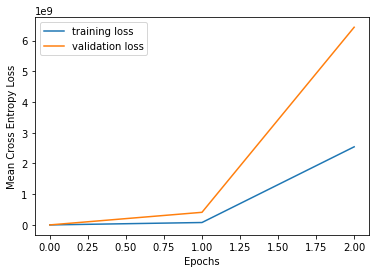

In [14]:
plt.plot(training_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Cross Entropy Loss')
#plt.ylim(0.0, 10)
plt.legend()

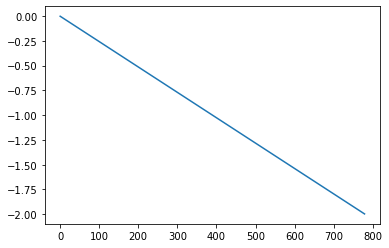

In [15]:
plt.plot(lr_history)

0.1


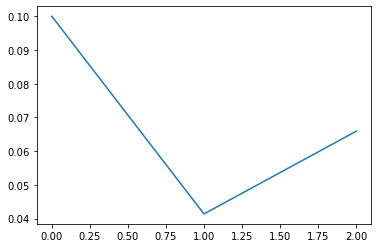

In [16]:
plt.plot(validation_accuracy)
print(max(validation_accuracy))

In [17]:
import csv
from google.colab import files

with open('train_loss', 'w') as f:
    write = csv.writer(f)
    write.writerow(training_loss)

with open('val_loss', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_loss)

with open('val_accuracy', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(validation_accuracy)
    
with open('lr_history', 'w') as f: 
    write = csv.writer(f)  
    write.writerow(lr_history)

files.download('train_loss')
files.download('val_loss')
files.download('val_accuracy')
files.download('lr_history')

ModuleNotFoundError: No module named 'google'